In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import torch.nn.functional as F  # useful stateless functions

In [2]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
#USE_GPU = True
USE_GPU = False

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [4]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [5]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU. 
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-1.6294,  1.9337, -1.7386, -0.1637,  0.3529],
        [ 0.1375,  0.1286, -0.3797,  1.1344, -0.9206],
        [-0.3009, -0.1821,  1.1619,  0.3779, -0.8524]], requires_grad=True)

In [23]:
def check_accuracy_part34(loader_test_val, loader_test_train, model, verbose=True):
    val_accuracy = 0.0
    train_accuracy = 0.0
    acc = 0.0
    if loader_test_val.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader_test_val:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = None
            scores = model(x)
            preds = None
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        val_accuracy = acc*100
        if verbose:
            print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    acc = 0.0
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for x, y in loader_test_train:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = None
            scores = model(x)
            preds = None
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        train_accuracy = acc*100
        if verbose:
            print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return val_accuracy, train_accuracy

In [35]:
def train_part34(model, optimizer, loader_test_val, loader_test_train, epochs=1, verbose=True):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    losses = list()
    val_accuracies = list()
    train_accuracies = list()
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_test_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            losses.append(loss.item())
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            print_every = 1
            if t % print_every == 0 and verbose:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                val_accuracy, train_accuracy = check_accuracy_part34(loader_test_val, loader_test_train, model, verbose=True)
                val_accuracies.append(val_accuracy)
                train_accuracies.append(train_accuracy)
                print()
    return losses, val_accuracies, train_accuracies

In [8]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [20]:
channel_1 = 32
channel_2 = 64
channel_3 = 128
channel_4 = 256
channel_5 = 512
in_channel = 3

In [21]:
def getmodel():
    channel_1 = 32
    channel_2 = 64
    channel_3 = 128
    channel_4 = 256
    channel_5 = 512
    in_channel = 3
    model = nn.Sequential(
    nn.Conv2d(in_channel, channel_1, (5, 5), padding=2),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, (5, 5), padding=2),
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), #16x16 
    nn.Conv2d(channel_2, channel_3, (3, 3), padding=1),
    nn.BatchNorm2d(channel_3),
    nn.ReLU(),
    nn.Conv2d(channel_3, channel_4, (3, 3), padding=1),
    nn.BatchNorm2d(channel_4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), #8x8
    nn.Conv2d(channel_4, channel_5, (3, 3), padding=1),
    nn.BatchNorm2d(channel_5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=8, stride=8, padding=0),
    Flatten(),
    nn.Linear(channel_5 * 1 * 1, 10),
    )
    return model

In [31]:
class NineLayerConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        channel_1 = 32
        channel_2 = 64
        channel_3 = 128
        channel_4 = 256
        channel_5 = 512
        in_channel = 3
        self.conv1 = nn.Conv2d(in_channel, channel_1, (5, 5), padding=2)
        self.batchnorm1 = nn.BatchNorm2d(channel_1)
        self.conv2 = nn.Conv2d(channel_1, channel_2, (5, 5), padding=2)
        self.batchnorm2 = nn.BatchNorm2d(channel_2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)#16x16
        self.conv3 = nn.Conv2d(channel_2, channel_3, (3, 3), padding=1)
        self.batchnorm3 = nn.BatchNorm2d(channel_3)
        self.conv4 = nn.Conv2d(channel_3, channel_4, (3, 3), padding=1)
        self.batchnorm4 = nn.BatchNorm2d(channel_4)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)#8x8
        self.conv5 = nn.Conv2d(channel_4, channel_5, (3, 3), padding=1)
        self.batchnorm5 = nn.BatchNorm2d(channel_5)
        self.fc = nn.Linear(channel_5 * 8 * 8, 10)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal(m.weight.data, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        conv_relu1 = F.relu(self.batchnorm1(self.conv1(x)))
        conv_relu2 = F.relu(self.batchnorm2(self.conv2(conv_relu1)))
        max_pool1 = self.maxpool1(conv_relu2)
        conv_relu3 = F.relu(self.batchnorm3(self.conv3(max_pool1)))
        conv_relu4 = F.relu(self.batchnorm4(self.conv4(conv_relu3)))
        max_pool2 = self.maxpool2(conv_relu4)
        conv_relu5 = F.relu(self.batchnorm5(self.conv5(max_pool2)))
        scores = self.fc(flatten(conv_relu5)) 
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores

In [52]:
def conv3x3(in_channels, out_channels, stride=1):
    """3x3 kernel size with padding convolutional layer in ResNet BasicBlock."""
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


class BasicBlock(nn.Module):
    """Basic Block of ReseNet."""

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """Basic Block of ReseNet Builder."""
        super(BasicBlock, self).__init__()

        # First conv3x3 layer
        self.conv1 = conv3x3(in_channels, out_channels, stride)

        #  Batch Normalization
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        # ReLU Activation Function
        self.relu = nn.ReLU(inplace=True)

        # Second conv3x3 layer
        self.conv2 = conv3x3(out_channels, out_channels)

        #  Batch Normalization
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        # downsample for `residual`
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """Forward Pass of Basic Block."""
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        return out

In [57]:
class ResNet(nn.Module):
    """Residual Neural Network."""

    def __init__(self, block, duplicates, num_classes=100):
        """Residual Neural Network Builder."""
        super(ResNet, self).__init__()

        self.in_channels = 32
        self.conv1 = conv3x3(in_channels=3, out_channels=32)
        self.bn = nn.BatchNorm2d(num_features=32)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=0.02)

        # block of Basic Blocks
        self.conv2_x = self._make_block(block, duplicates[0], out_channels=32)
        self.conv3_x = self._make_block(block, duplicates[1], out_channels=64, stride=2)
        self.conv4_x = self._make_block(block, duplicates[2], out_channels=128, stride=2)
        self.conv5_x = self._make_block(block, duplicates[3], out_channels=256, stride=2)

        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=1)
        self.fc_layer = nn.Linear(256, num_classes)

        # initialize weights
        # self.apply(initialize_weights)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_block(self, block, duplicates, out_channels, stride=1):
        """
        Create Block in ResNet.

        Args:
            block: BasicBlock
            duplicates: number of BasicBlock
            out_channels: out channels of the block

        Returns:
            nn.Sequential(*layers)
        """
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(num_features=out_channels)
            )

        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, duplicates):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass of ResNet."""
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        # Stacked Basic Blocks
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)

        return out

In [58]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [59]:
def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))
    print(y.size())

In [60]:
test()

torch.Size([1, 100])


In [61]:
count = 1
results = {}
best_val = 0.0
best_optimizier = None
best_model = None
best_losses = None
best_train_accuracies = None
best_val_accuracies = None
best_scale_r = 0.0
best_rate_r = 0.0
for i in range(count):
    scale_r = np.random.uniform(-8, -1)
    rate_r = np.random.uniform(-5, -1)
    weight_scale = 10**scale_r
    learning_rate = 10**rate_r
    weight_scale = 1e-5
    learning_rate = 3e-3
    print('scale_r', scale_r)
    print('weight_scale', weight_scale)
    print('rate_r', rate_r)
    print('learning_rate', learning_rate)

    #optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True, weight_decay=weight_scale)  
    cifar10_small_test = dset.CIFAR10('./cs231n/datasets', train=True, download=True, transform=transform)
    loader_small_test = DataLoader(cifar10_small_test, batch_size=32, sampler=sampler.SubsetRandomSampler(range(64)))
    model = None
    model = ResNet(BasicBlock, [2,2,2,2])
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                        momentum=0.9, nesterov=True, weight_decay=weight_scale)
    losses, val_accuracies, train_accuracies = train_part34(model, optimizer, loader_val, loader_small_test, epochs=10, verbose=True)
    val_acc = val_accuracies[-1]
    train_acc = train_accuracies[-1]
    results[(scale_r, rate_r)] = (weight_scale, learning_rate, val_acc, train_acc)
    if (best_val < train_acc):
      best_val = train_acc
      best_optimizier = optimizer
      best_losses = losses
      best_train_accuracies = train_accuracies
      best_val_accuracies = val_accuracies
      best_model = model
      best_rate_r = rate_r
      best_scale_r = scale_r
    print('###############')

scale_r -1.0460694844692302
weight_scale 1e-05
rate_r -1.3348243122746908
learning_rate 0.003
Files already downloaded and verified
Iteration 0, loss = 5.9288
Checking accuracy on validation set
Got 86 / 1000 correct (8.60)
Got 9 / 64 correct (14.06)

Iteration 1, loss = 4.8047
Checking accuracy on validation set
Got 77 / 1000 correct (7.70)
Got 12 / 64 correct (18.75)

Iteration 0, loss = 2.6816
Checking accuracy on validation set
Got 123 / 1000 correct (12.30)
Got 17 / 64 correct (26.56)

Iteration 1, loss = 2.2902
Checking accuracy on validation set
Got 93 / 1000 correct (9.30)
Got 19 / 64 correct (29.69)

Iteration 0, loss = 1.2803
Checking accuracy on validation set
Got 128 / 1000 correct (12.80)
Got 25 / 64 correct (39.06)

Iteration 1, loss = 1.7837
Checking accuracy on validation set
Got 97 / 1000 correct (9.70)
Got 31 / 64 correct (48.44)

Iteration 0, loss = 0.6426
Checking accuracy on validation set
Got 121 / 1000 correct (12.10)
Got 45 / 64 correct (70.31)

Iteration 1, los

In [62]:
for item in sorted(results):
    scale_r, rate_r = item
    weight_scale, learning_rate, val_acc, train_acc = results[item]
    print('scale_r: %e, rate_r: %e, ws: %f, lr: %f,  train_acc: %f' % (scale_r, rate_r, weight_scale, learning_rate, train_acc))

scale_r: -1.046069e+00, rate_r: -1.334824e+00, ws: 0.000010, lr: 0.003000,  train_acc: 100.000000


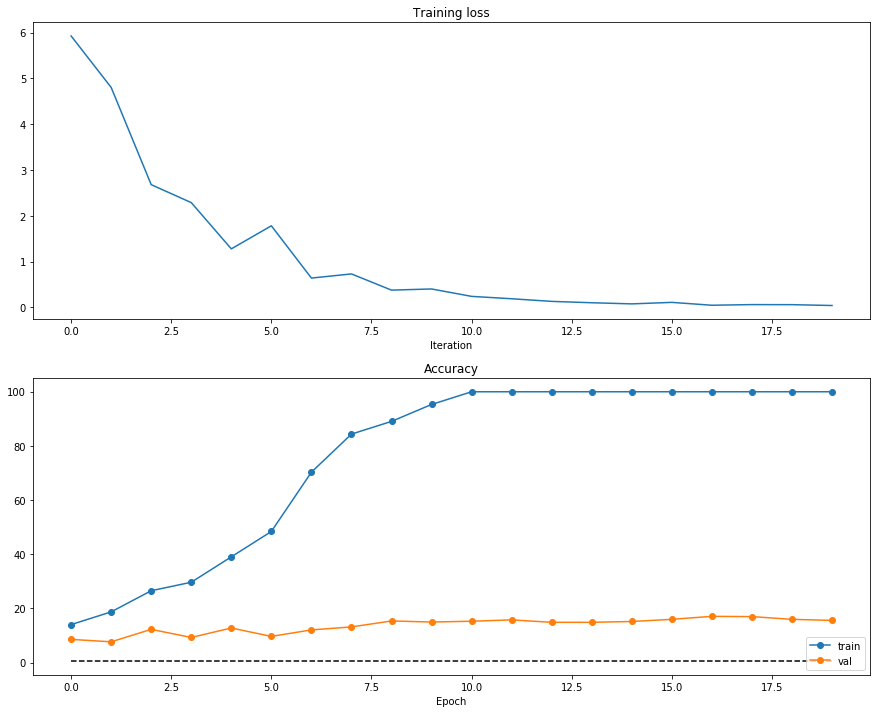

In [63]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(best_losses)
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(best_train_accuracies, '-o', label='train')
plt.plot(best_val_accuracies, '-o', label='val')
plt.plot([0.5] * len(best_val_accuracies), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()